# MNIST Tutorial

Welcome to Flax NNX! This tutorial will guide you through building and training a simple convolutional
neural network (CNN) on the MNIST dataset using the Flax NNX API. Flax NNX is a Python neural network library
built upon [JAX](https://github.com/google/jax) and currently offered as an experimental module within
[Flax](https://github.com/google/flax).

## 1. Install Flax

If `flax` is not installed in your environment, you can install it from PyPI, uncomment and run the
following cell:

In [1]:
import jax
import jax.numpy as jnp
from tensorflow.keras.datasets import mnist
from flax import linen as nn
import matplotlib.pyplot as plt
%matplotlib inline
import pdb
import optax
import copy

## 2. Load the MNIST Dataset

First, the MNIST dataset is loaded and prepared for training and testing using
Tensorflow Datasets. Image values are normalized, the data is shuffled and divided
into batches, and samples are prefetched to enhance performance.

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train, Y_train, X_test, Y_test = jnp.expand_dims(jnp.array(X_train/255), axis=-1), jnp.expand_dims(jnp.array(Y_train), axis=-1), jnp.expand_dims(jnp.array(X_test/255), axis=-1), jnp.expand_dims(jnp.array(Y_test), axis=-1)

In [3]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28, 1), (60000, 1), (10000, 28, 28, 1), (10000, 1))

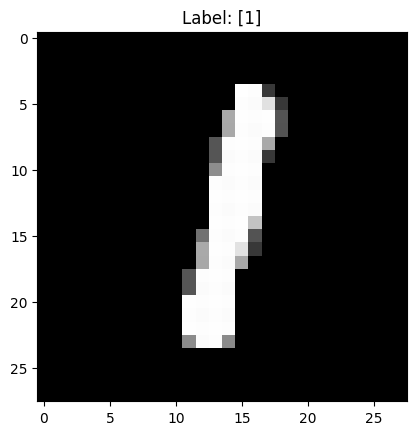

In [4]:
sample = 211
image = X_train[sample]*255

# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.title('Label: {}'.format(Y_train[sample]))
plt.show()

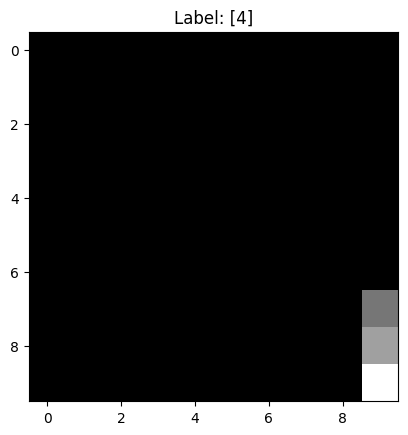

In [5]:
sample = 765
image = X_test[sample]*255

# plot the sample
fig = plt.figure
plt.imshow(image[0:10, 0:10, :], cmap='gray')
plt.title('Label: {}'.format(Y_test[sample]))
plt.show()

In [6]:
@jax.jit
def get_sample_and_label(idx, inputs, labels):
    return inputs[idx], labels[idx]

arr = jnp.array([32,67,432,2])
xb, yb = jax.vmap(get_sample_and_label, in_axes=(0,None,None))(arr, X_train, Y_train)
xb.shape, yb.shape

((4, 28, 28, 1), (4, 1))

In [7]:
@jax.jit
def get_mask(idx, size):
    rows_mask = jnp.ones(shape=(28,28))*jnp.arange(0,28)
    cols_mask = jnp.transpose(rows_mask)

    rows_mask = jnp.where((rows_mask>=idx)&(rows_mask<idx+size), 1, 0)
    cols_mask = jnp.where((cols_mask>=idx)&(cols_mask<idx+size), 1, 0)

    mask = -1*((rows_mask*cols_mask)-1)
    return jnp.reshape(mask, (28,28,1)), jnp.reshape(rows_mask*cols_mask, (28,28,1))


[11]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

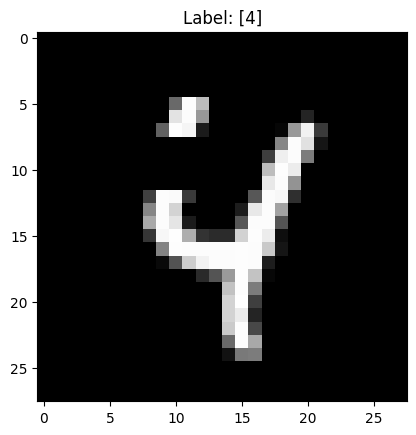

In [8]:
key = jax.random.PRNGKey(42)  # Replace 42 with any random seed
subkey_a, subkey_b = jax.random.split(key)
ixx = jax.random.randint(subkey_a, shape=(1,), minval=0, maxval=23)
print(ixx)
mask, _ = get_mask(8, 4)
print(mask[...,-1])
masked_img = X_test[sample]*mask

fig = plt.figure
plt.imshow(masked_img, cmap='gray')
plt.title('Label: {}'.format(Y_test[sample]))
plt.show()
# ix = jax.random.permutation(key, jnp.arange(0,len(X_train)))
# ix = jnp.array([[54,0,0,0],[876,0,0,0]])
# print(ix.shape)
# dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(0, None, None))
# dynamic_slice_vmap(X_train, ix, (28, 28, 1))

In [9]:
@jax.jit
def get_sample(idx, idxx, size, inputs):
    mask, reverse_mask = get_mask(idxx, size)
    imgg = inputs[idx]
    masked_imgg = inputs[idx]*mask
    return masked_imgg, imgg


In [10]:
arr = jnp.array([32,67,432,2])

xb, yb = jax.vmap(get_sample, in_axes=(0,None, None, None))(arr, 12, 8, X_test)
xb.shape, yb.shape

((4, 28, 28, 1), (4, 28, 28, 1))

(8, 28, 28, 1)


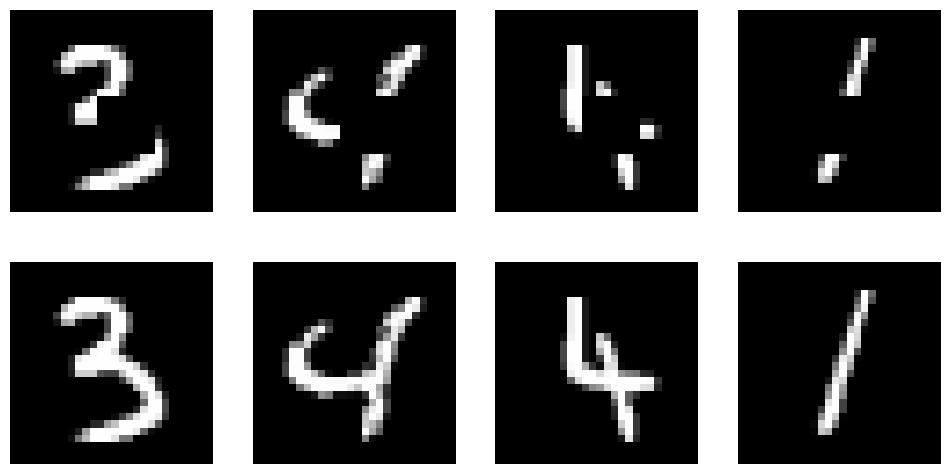

In [11]:
imggs = jnp.vstack([xb, yb])
print(imggs.shape)
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(imggs[i, ..., 0]*255, cmap='gray')
    ax.axis('off')

In [12]:
BATCH_SIZE = 64
learning_rate = 0.1
momentum = 0.9
train_length = len(X_train)//BATCH_SIZE
kernel_s = 2

In [13]:
class CNN(nn.Module):
    """A simple CNN model."""
        
    @nn.compact
    def __call__(self, inputs):
        x = jax.nn.silu(nn.Conv(features=64, kernel_size=(kernel_s, kernel_s))(inputs))
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = jax.nn.silu(nn.Conv(features=128, kernel_size=(kernel_s, kernel_s))(x))
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = jax.nn.silu(nn.Conv(features=256, kernel_size=(kernel_s, kernel_s))(x))

        # for i in range(2):
        #     conv_s = jax.nn.silu(nn.Conv(features=32, kernel_size=(kernel_s+i+1, kernel_s+i+1))(inputs))
        #     # pdb.set_trace()
        #     conv_s = nn.max_pool(conv_s, window_shape=(2, 2), strides=(2, 2))
        #     conv_s = jax.nn.silu(nn.Conv(features=64, kernel_size=(kernel_s+i+1, kernel_s+i+1))(conv_s))
        #     conv_s = nn.max_pool(conv_s, window_shape=(2, 2), strides=(2, 2))
        #     x = jnp.dstack([x, conv_s])
        
        x = x.reshape(x.shape[0], -1)  # flatten
        x = jax.nn.silu(nn.Dense(256)(x))
        x = nn.Dense(10)(x)
        return jnp.expand_dims(x, axis=1)

model = CNN()
params = model.init(jax.random.PRNGKey(451),jnp.ones((1,28,28,1)))
n_params = sum(p.size for p in jax.tree_util.tree_leaves(params))
print(f"Total number of parameters: {n_params:_}")

Total number of parameters: 3_378_634


In [14]:
# opt = optax.sgd(learning_rate, momentum)
opt = optax.adamw(learning_rate=0.001)


opt_state = opt.init(params)

In [15]:
def loss_fun(params, x, y):
    logits = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

@jax.jit
def eval_step(params, x, y):
    logits = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

In [16]:
%%time

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

eval_iters = 4000

@jax.jit
def step(idx, params, opt_state):
    xb, yb = jax.vmap(get_sample_and_label, in_axes=(0,None,None))(idx, X_train, Y_train)
    (loss, train_accuracy), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, train_accuracy

for i in range(eval_iters):
    key, subkey = jax.random.split(key)
    iix = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_train))
    params, opt_state, loss, train_accuracy = step(iix, params, opt_state)

    # once every N_FREQ_EVAL we compute loss on the validation set
    if i%100 == 0:
        key, subkey = jax.random.split(key)
        indxs = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_test))
        xt, yt = jax.vmap(get_sample_and_label, in_axes=(0,None,None))(indxs, X_test, Y_test)
        eval_loss, eval_accuracy = eval_step(params, xt, yt)
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print('####################################################################################################')
        print("Step: ", i,"\t\t Train Loss: ", format(loss, ".6f"),"\t\t Train Accuracy: ", format(train_accuracy, ".2%"))
        print("Step: ", i,"\t\t Eval Loss: ", format(eval_loss, ".6f"),"\t\t Eval Accuracy: ", format(eval_accuracy, ".2%"))

####################################################################################################
Step:  0 		 Train Loss:  2.303749 		 Train Accuracy:  9.38%
Step:  0 		 Eval Loss:  2.301695 		 Eval Accuracy:  7.81%
####################################################################################################
Step:  100 		 Train Loss:  0.208479 		 Train Accuracy:  95.31%
Step:  100 		 Eval Loss:  0.145857 		 Eval Accuracy:  93.75%
####################################################################################################
Step:  200 		 Train Loss:  0.118255 		 Train Accuracy:  95.31%
Step:  200 		 Eval Loss:  0.177622 		 Eval Accuracy:  95.31%
####################################################################################################
Step:  300 		 Train Loss:  0.148438 		 Train Accuracy:  95.31%
Step:  300 		 Eval Loss:  0.026998 		 Eval Accuracy:  98.44%
####################################################################################################
Step:

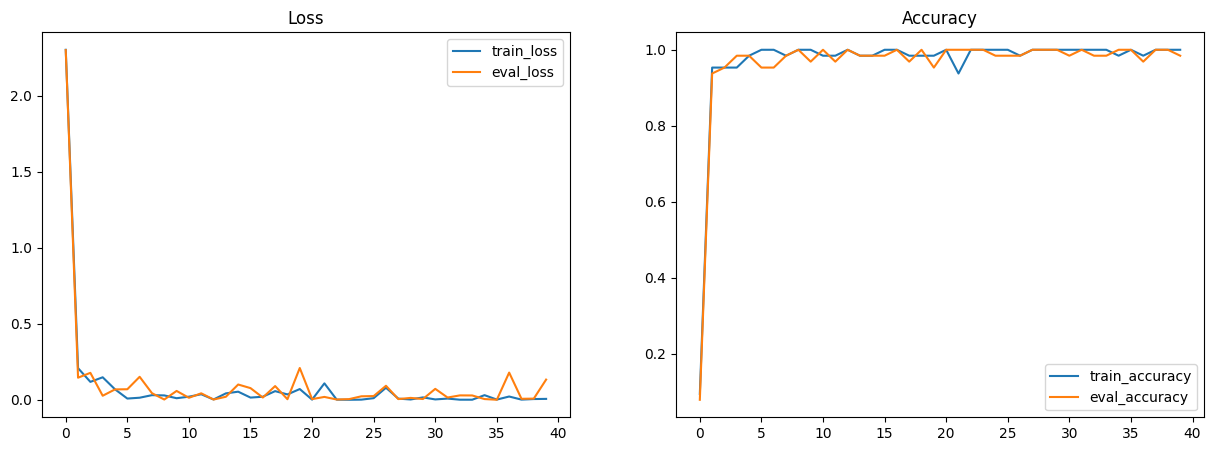

<Figure size 640x480 with 0 Axes>

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

## 3. Define the Network with Flax NNX

Create a convolutional neural network with Flax NNX by subclassing `nnx.Module`.

In [21]:
class Feat_Model(nn.Module):
    """A simple CNN model."""
        
    @nn.compact
    def __call__(self, inputs):

#         pdb.set_trace()
        x = jax.nn.silu(nn.Conv(features=64, kernel_size=(kernel_s, kernel_s))(inputs))
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = jax.nn.silu(nn.Conv(features=128, kernel_size=(kernel_s, kernel_s))(x))
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = jax.nn.silu(nn.Conv(features=256, kernel_size=(kernel_s, kernel_s))(x))

        
        return x

features_model = Feat_Model()
new_params = features_model.init(jax.random.PRNGKey(451),jnp.ones((1,28,28,1)))
new_params = copy.deepcopy(params)
new_params['params'].pop('Dense_0')
new_params['params'].pop('Dense_1')
n_params = sum(p.size for p in jax.tree_util.tree_leaves(new_params))
print(f"Total number of parameters: {n_params:_}")

Total number of parameters: 164_544


### Run model

Let's put our model to the test!  We'll perform a forward pass with arbitrary data and print the results.

In [22]:
base_params = copy.deepcopy(params)
base_params['params'].pop('Dense_0')
base_params['params'].pop('Dense_1')
base_params['params'].keys(), new_params['params'].keys()

(dict_keys(['Conv_0', 'Conv_1', 'Conv_2']),
 dict_keys(['Conv_0', 'Conv_1', 'Conv_2']))

In [23]:
y = features_model.apply(base_params, jnp.ones((3, 28, 28, 1)))
y.shape

(3, 7, 7, 256)

In [24]:
optax.l2_loss(features_model.apply(params, xb),features_model.apply(params, yb)).sum()
# optax.l1_loss(model.apply(params, xb),model.apply(params, yb)).mean()
# optax.huber_loss(model.apply(params, xb), model.apply(params, yb), delta=1.0).mean()

Array(200.46225, dtype=float32)

## 4. Create Optimizer and Metrics

In Flax NNX, we create an `Optimizer` object to manage the model's parameters and apply gradients during training. `Optimizer` receives the model's reference so it can update its parameters, and an `optax` optimizer to define the update rules. Additionally, we'll define a `MultiMetric` object to keep track of the `Accuracy` and the `Average` loss.

In [25]:
# opt = optax.sgd(learning_rate, momentum)
opt1 = optax.adamw(learning_rate=0.001)


opt_state1 = opt1.init(new_params)

## 5. Define step functions

We define a loss function using cross entropy loss (see more details in [`optax.softmax_cross_entropy_with_integer_labels()`](https://optax.readthedocs.io/en/latest/api/losses.html#optax.softmax_cross_entropy_with_integer_labels)) that our model will optimize over. In addition to the loss, the logits are also outputted since they will be used to calculate the accuracy metric during training and testing. During training, we'll use `nnx.value_and_grad` to compute the gradients and update the model's parameters using the optimizer. During both training and testing, the loss and logits are used to calculate the metrics.

In [26]:
def loss_fun(params, x, feats_y):
    feats_x = features_model.apply(params, x)
    
    return optax.l2_loss(feats_x, feats_y).sum()

@jax.jit
def eval_step(params, x, feats_y):
    feats_x = features_model.apply(params, x)
    
    return optax.l2_loss(feats_x, feats_y).sum()

The [`nnx.jit`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/transforms.html#flax.nnx.jit) decorator traces the `train_step` function for just-in-time compilation with
[XLA](https://www.tensorflow.org/xla), optimizing performance on
hardware accelerators. `nnx.jit` is similar to [`jax.jit`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html#jax.jit),
except it can transforms functions that contain Flax NNX objects as inputs and outputs.

**NOTE**: in the above code we performed serveral inplace updates to the model, optimizer, and metrics, and we did not explicitely return the state updates. This is because Flax NNX transforms respect reference semantics for Flax NNX objects, and will propagate the state updates of the objects passed as input arguments. This is a key feature of Flax NNX that allows for a more concise and readable code.

## 6. Train and Evaluate

Now we train a model using batches of data for 10 epochs, evaluate its performance
on the test set after each epoch, and log the training and testing metrics (loss and
accuracy) throughout the process. Typically this leads to a model with around 99% accuracy.

In [27]:
# %%time

# all_train_losses = []
# all_eval_losses = []


# eval_iters = 3000

# @jax.jit
# def step(idx, iiix, size, new_params, base_params, opt_state1):
#     xb, yb = jax.vmap(get_sample, in_axes=(0,None, None, None))(idx, iiix, size, X_train)
#     feats_y = features_model.apply(base_params, yb)
# #     print(xb.shape, yb.shape, feats_y.shape)
#     loss, grad = jax.value_and_grad(loss_fun)(new_params, xb, feats_y)
#     updates, opt_state1 = opt1.update(grad, opt_state1, new_params)
#     new_params = optax.apply_updates(new_params, updates)
#     return new_params, opt_state1, loss

# for jj in jnp.array([4,6,8]):
#     for i in range(eval_iters):
#         key, subkey = jax.random.split(key)
#         iix = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_train))
#         ixx = jax.random.randint(subkey_a, shape=(1,), minval=9, maxval=20)
#         new_params, opt_state1, loss = step(iix, ixx, jj, new_params, base_params, opt_state1)

#         # once every N_FREQ_EVAL we compute loss on the validation set
#         if i%100 == 0:
#             key, subkey = jax.random.split(key)
#             indxs = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_test))
#             xt, yt = jax.vmap(get_sample, in_axes=(0,None, None, None))(indxs, ixx, jj, X_test)
#             feats_y = features_model.apply(base_params, yt)
#             eval_loss = eval_step(new_params, xt, feats_y)
#             all_train_losses.append(loss)
#             all_eval_losses.append(eval_loss)

#             print('####################################################################################################')
#             print("Step: ", eval_iters*(jj//2-2)+i,"\t\t Train Loss: ", format(loss, ".6f"))
#             print("Step: ", eval_iters*(jj//2-2)+i,"\t\t Eval Loss: ", format(eval_loss, ".6f"))


## 7. Visualize Metrics

Use Matplotlib to create plots for loss and accuracy.

In [28]:
# fig = plt.figure
# plt.plot(all_train_losses, label='train_loss')
# plt.plot(all_eval_losses, label='eval_loss')
# plt.title('Loss')
# plt.show()

In [29]:
class Up_Model(nn.Module):
    """A simple CNN model."""
        
    @nn.compact
    def __call__(self, inputs):
#         pdb.set_trace()
        x = features_model.apply(params, inputs)
        
        conv3t = jax.nn.silu(nn.ConvTranspose(x.shape[-1]//2, kernel_size = kernel_s, padding = 'SAME')(x))
    
        uconv2 = jnp.repeat(jnp.repeat(conv3t, repeats=2, axis=1), repeats=2, axis=2) # jax.image.resize(conv3t, shape=(conv3t.shape[0], conv3t.shape[1] * 2, conv3t.shape[2] * 2, conv3t.shape[3]), method='bilinear')
        conv2T = jax.nn.silu(nn.ConvTranspose(uconv2.shape[-1]//2, kernel_size = kernel_s, padding = 'SAME')(uconv2))
        
        uconv1 = jnp.repeat(jnp.repeat(conv2T, repeats=2, axis=1), repeats=2, axis=2) # jax.image.resize(conv2T, shape=(conv2T.shape[0], conv2T.shape[1] * 2, conv2T.shape[2] * 2, conv2T.shape[3]), method='bilinear')
        conv1T = jax.nn.silu(nn.ConvTranspose(1, kernel_size = kernel_s, padding = 'SAME')(uconv1))

        
        x = (conv1T - conv1T.min())/(conv1T.max()-conv1T.min())
        

        
#         x = x.reshape(x.shape[0], -1)  # flatten
#         x = jax.nn.silu(nn.Dense(256)(x))
#         x = nn.Dense(1)(conv1T)
#         x = jnp.expand_dims(x, axis=1)
        
        return x + inputs

pred_img_model = Up_Model()
var_params = pred_img_model.init(jax.random.PRNGKey(451),jnp.ones((1,28,28,1)))
n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))
print(f"Total number of parameters: {n_params:_}")
output = pred_img_model.apply(var_params, jnp.ones((1,28,28,1)))
print(output.shape)

Total number of parameters: 82_241
(1, 28, 28, 1)


In [30]:
opt2 = optax.adamw(learning_rate=0.001)


opt_state2 = opt.init(var_params)

In [31]:
def img_loss_fun(params, x, y):
    pred_img = pred_img_model.apply(params, x)
    return optax.l2_loss(pred_img, y).sum()

@jax.jit
def img_eval_step(params, x, y):
    pred_img = pred_img_model.apply(params, x)
    return optax.l2_loss(pred_img, y).sum()

In [32]:
%%time

all_train_losses = []

all_eval_losses =  []

eval_iters = 3000

@jax.jit
def step(idx, iiix, size, var_params, base_params, opt_state2):
    xb, yb = jax.vmap(get_sample, in_axes=(0,None, None, None))(idx, iiix, size, X_train)
    loss, grad = jax.value_and_grad(img_loss_fun)(var_params, xb, yb)
    updates, opt_state2 = opt2.update(grad, opt_state2, var_params)
    var_params = optax.apply_updates(var_params, updates)
    return var_params, opt_state2, loss

for jj in jnp.array([4,6,8]):
    for i in range(eval_iters):
        key, subkey = jax.random.split(key)
        iix = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_train))
        ixx = jax.random.randint(subkey_a, shape=(1,), minval=9, maxval=20)
        var_params, opt_state2, loss = step(iix, ixx, jj, var_params, base_params, opt_state2)

        # once every N_FREQ_EVAL we compute loss on the validation set
        if i%100 == 0:
            key, subkey = jax.random.split(key)
            indxs = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_test))
            xt, yt = jax.vmap(get_sample, in_axes=(0,None, None, None))(indxs, ixx, jj, X_test)
            eval_loss = img_eval_step(var_params, xt, yt)
            all_train_losses.append(loss)
            all_eval_losses.append(eval_loss)

            print('####################################################################################################')
            print("Step: ", eval_iters*(jj//2-2)+i,"\t\t Train Loss: ", format(loss, ".6f"))
            print("Step: ", eval_iters*(jj//2-2)+i,"\t\t Eval Loss: ", format(eval_loss, ".6f"))


####################################################################################################
Step:  0 		 Train Loss:  6035.402344
Step:  0 		 Eval Loss:  3489.074707
####################################################################################################
Step:  100 		 Train Loss:  266.486633
Step:  100 		 Eval Loss:  263.715363
####################################################################################################
Step:  200 		 Train Loss:  211.900146
Step:  200 		 Eval Loss:  195.530640
####################################################################################################
Step:  300 		 Train Loss:  181.466141
Step:  300 		 Eval Loss:  186.089722
####################################################################################################
Step:  400 		 Train Loss:  181.839050
Step:  400 		 Eval Loss:  158.423035
####################################################################################################
Step:  500 		 Train L

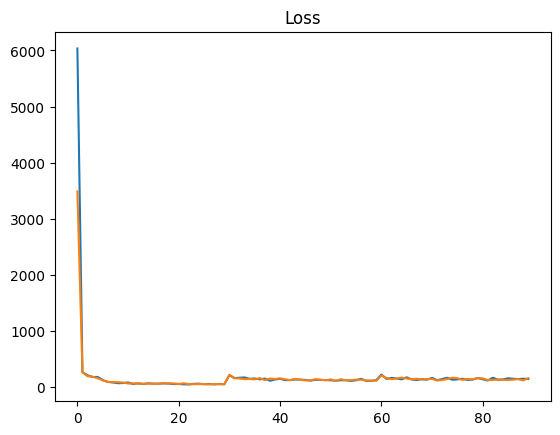

In [33]:
fig = plt.figure
plt.plot(all_train_losses, label='train_loss')
plt.plot(all_eval_losses, label='eval_loss')
plt.title('Loss')
plt.show()

## 10. Perform inference on test set

Define a jitted inference function, `pred_step`, to generate predictions on the test set using the learned model parameters. This will enable you to visualize test images alongside their predicted labels for a qualitative assessment of model performance.

(15, 28, 28, 1)


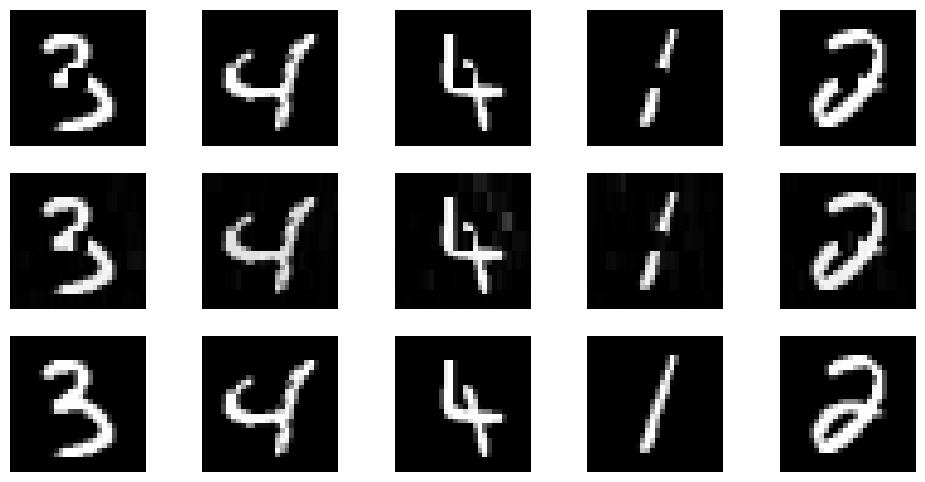

In [42]:
jj = 234
test_batch = X_test[jj:jj+5]
test_batch_label= Y_test[jj:jj+5]

arr = jnp.array([32,67,432,2, 875])

xp, yp = jax.vmap(get_sample, in_axes=(0,None, None, None))(arr, 12, 4, X_test)
pred_imgs = pred_img_model.apply(var_params, xp)


imggs = jnp.vstack([xp, pred_imgs, yp])
print(imggs.shape)
fig, axs = plt.subplots(3, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(imggs[i, ..., 0]*255, cmap='gray')
    ax.axis('off')

Congratulations! You made it to the end of the annotated MNIST example.

In [36]:
def pred_step(params, batch):
    logits = model.apply(params, batch)
    return logits.argmax(axis=2)

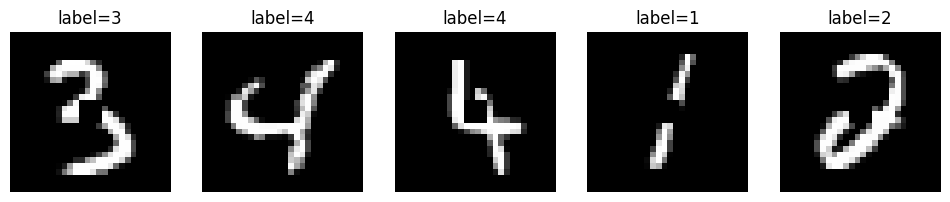

In [43]:
# jj = 234
# test_batch = X_test[jj:jj+25]
# test_batch_label= Y_test[jj:jj+25]

# test_batch, yb = jax.vmap(get_sample, in_axes=(0,None, None, None))(iix, ixx, 6, X_test)
pred = pred_step(params, xp)

fig, axs = plt.subplots(1, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(xp[i, ..., 0]*255, cmap='gray')
    ax.set_title(f'label={pred[i][0]}')
    ax.axis('off')